# CSCI 3202, Spring 2018: Practicum

---

<a id='top'></a>

This practicum is due on Moodle by **4 PM on Friday 4 May 2018**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

**The rules:**

1. All work, code and analysis must be **your own**.
1. You may use your course notes, posted lecture slides, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python.
1. You may **not** post to message boards or other online resources asking for help.
1. **You may not collaborate with classmates or anyone else.**
1. This is meant to be like a coding portion of your final exam. So, I will be much less helpful than I typically am with homework. For example, I will not check answers, help debug your code, and so on.
1. If you have a question, post it first as a **private** Piazza message. If I decide that it is appropriate for the entire class, then I will make it a public post (and anonymous).
1. If something is left open-ended, it is probably because I intend for you to code it up however you want, and only care about the plots/analysis I see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name:**

---

Shortcuts:  [Top](#top) || [1. Search](#p1) | [2. Bayes nets](#p2) | [3. Markov chains](#p3) | [4. Reinforcement learning](#p4) || [Bottom](#bottom)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import unittest
import heapq
from matplotlib import colors
from collections import defaultdict

In [2]:
class Tests_Problem1(unittest.TestCase):
    '''
    test suite for Problem 1 B) Heuristic functions
    '''
    def test_cols(self):
        dist = heuristic_cols((4, 16), (25, 9))
        self.assertEqual(dist, 21)
    def test_rows(self):
        dist = heuristic_rows((4,16), (25, 9))
        self.assertEqual(dist, 7)
    def test_eucl(self):
        dist = heuristic_eucl((4,16), (25, 9))
        self.assertEqual(round(dist,4), 22.1359)
    def test_max(self):
        pass
    def test_adjacent(self):
        adj = {(1,16): 1, (2,14):np.sqrt(2), (2,15):1, (2,16):np.sqrt(2)}
        fun_a = adjacent_states((1,15))
        self.assertEqual(adj, fun_a)

<a/ id='p1'></a>

---
## [25 pts] Problem 1:  Route-finding

Consider the map of the area to the west of the Engineering Center given below, with a fairly coarse Cartesian grid superimposed.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/engineering_center_grid_zoom.png" style="width: 800px;"/>

In [3]:
def plot_maze(maze, path=None):
    ''' visualize the binary `maze` (assumed numpy array) and solution `path` (if provided)'''

    nrow, ncol = maze.shape
    
    # create colormap
    cmap = colors.ListedColormap(['coral', 'slategray'])

    fig, ax = plt.subplots()
    ax.imshow(maze, cmap=cmap, origin='lower')
    
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k')
    ax.set_xticks(np.arange(-.5, ncol, 1))
    ax.set_yticks(np.arange(-.5, nrow, 1))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    # now draw the solution path, if one is provided
    if path:
        for p in range(len(path)-1):
            point = path[p]
            nextpoint = path[p+1]
            plt.plot([point[0],nextpoint[0]], [point[1], nextpoint[1]], c='black')
    plt.title("A map to our universe")
    plt.xlabel("The x direction increases this way ->")
    plt.ylabel("The y direction increases this way ->")
    plt.show()

In [4]:
class Frontier_PQ:
    ''' frontier class for uniform search, ordered by path cost '''
    
    def __init__(self, start, cost):
        self.states = {}
        self.q = []
        self.add(start, cost)
        
    def add(self, state, cost):
        ''' push the new state and cost to get there onto the heap'''
        heapq.heappush(self.q, (cost, state))
        self.states[state] = cost

    def pop(self):
        (cost, state) = heapq.heappop(self.q)  # get cost of getting to explored state
        self.states.pop(state)    # and remove from frontier
        return (cost, state)

    def replace(self, state, cost):
        ''' found a cheaper route to `state`, replacing old cost with new `cost` '''
        self.states[state] = cost
        for i, (oldcost, oldstate) in enumerate(self.q):
            if oldstate==state and oldcost > cost:
                self.q[i] = (cost, state)
                heapq._siftdown(self.q, 0, i) # now i is posisbly out of order; restore
        return



The green square at $(x,y)=(1,15)$ is the starting location, and you would like to walk from there to the yellow square at $(25,9)$ with the **lowest total path cost**. The filled-in blue squares are obstacles, and you cannot walk through those locations.  You also cannot walk outside of this grid.

Legal moves in the North/South/East/West directions have a step cost of 1. Moves in the diagonal direction (for example, from $(1,15)$ to $(2,14)$) are allowed, but they have a step cost of $\sqrt{2}$. 

Of course, you can probably do this problem without a search algorithm. But (1) that will provide a useful "sanity check" for your answer, and (2) an AI agent cannot necessarily figure that out... without your help!

#### Part A
Write a function `adjacent_states(state)`:
* takes a single argument `state`, which is a tuple representing a valid state in this state space
* returns in some form the states reachable from `state` and the step costs. How exactly you do this is up to you.

Print to the screen the output for `adjacent_states((1,15))`.

In [5]:
def enumerate_walls():

    walls = []

    #generate upper right cube
    for i in range(21, 26):
        for j in range(11, 17):
            walls.append((i,j))

    #generate bottom middle object
    for i in range(5, 24):
        walls.append((i, 1))

    #generate middle cube object
    for i in range(10, 14):
        for j in range(9, 11):
            walls.append((i,j))
    for i in range(10, 15):
        for j in range(11, 13):
            walls.append((i, j))

    for i in range(11, 15):
        for j in range(13, 15):
            walls.append((i, j))

    x2 = 15
    x1 = 2
    #generate left object
    for i in range(1, 5):
        for j in range(x1, x2):
            walls.append((i,j))
        x2 -= 1
        x1 += 1
    return walls

wallz = enumerate_walls()
def check_wall(state, walls = wallz):
    if state not in walls:
        return True
    else:
        return False

In [6]:
def adjacent_states(state):
    '''
    return all adjacent states of current state
    '''
    adj = {}
    
    if state[0] > 1:#left
        x = state[0] - 1
        y = state[1]
        if check_wall((x,y)): adj[(x,y)] = 1
        
        if state[1] > 1: #left down
            y = state[1] - 1
            if check_wall((x,y)): adj[(x,y)] = np.sqrt(2)
            
        if state[1] <25: #left up
            y = state[1] + 1
            if check_wall((x,y)): adj[(x,y)] = np.sqrt(2)
            
    if state[0] < 25: #right
        x = state[0] + 1
        y = state[1]
        if check_wall((x,y)): adj[(x,y)] = 1
        
        if state[1] > 1:  #right down
            y = state[1] -1
            if check_wall((x,y)): adj[(x,y)] = np.sqrt(2) 
            
        if state[1] < 16: #right up
            y= state[1] + 1
            if check_wall((x,y)): adj[(x,y)] = np.sqrt(2) 
            
    if state[1] > 1: #down
        x = state[0]
        y = state[1] -1
        if check_wall((x,y)): adj[(x,y)] = 1
        
    if state[1] < 16: #up
        x = state[0]
        y = state[1] + 1 
        if check_wall((x,y)): adj[(x,y)] = 1
    return adj      

adjacent_states((1,15))

{(1, 16): 1,
 (2, 14): 1.4142135623730951,
 (2, 15): 1,
 (2, 16): 1.4142135623730951}

In [7]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem1("test_adjacent"))
unittest.TextTestRunner().run(tests_to_run)

.
----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

#### Part B
Three candidate heuristic functions might be:
1. `heuristic_cols(state, goal)` = number of columns between the argument `state` and the `goal`
1. `heuristic_rows(state, goal)` = number of rows between the argument `state` and the `goal`
1. `heuristic_eucl(state, goal)` = Euclidean distance between the argument `state` and the `goal`

Write a function `heuristic_max(state, goal)` that returns the maximum of all three of these heuristic functions for a given `state` and `goal`.

In [8]:
def heuristic_cols(state, goal):
    '''
    state and goal are tuples (column, row)
    number of columns between the argument state and the goal
    '''
    return abs(state[0] - goal[0])
def heuristic_rows(state, goal):
    '''
    state and goal are tuples (column, row)
    number of rows between the argument state and the goal
    '''
    return abs(state[1] - goal[1])

def heuristic_eucl(state, goal):
    x = np.abs(state[0] - goal[0])
    y = np.abs(state[1] - goal[1])
    return np.sqrt(x*x + y*y)

def heuristic_max(state, goal):
    '''
    returns the maximum of all three heuristic functions, heuristic_eucl(), herusitic_rows(), heuristic_cols()
    state and goal are tuples (column, row) pairs
    '''
    return max(heuristic_eucl(state, goal), heuristic_rows(state,goal), heuristic_cols(state, goal))

In [9]:
'''
I wrote my own test functions! Yay!
'''

tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem1("test_cols"))
tests_to_run.addTest(Tests_Problem1("test_rows"))
tests_to_run.addTest(Tests_Problem1("test_eucl"))
tests_to_run.addTest(Tests_Problem1("test_max")) # <- Except for this one. I don't want to write this out by hand. So it gets a freebie
unittest.TextTestRunner().run(tests_to_run)

....
----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

#### Part C
Is the Manhattan distance an admissible heuristic function for this problem?  Explain why or why not. A counterexample is a great way to prove that something is not true.

----
<span style="color:steelblue">**The Manhattan distance is inadmissable** in this case. The Manhattan distance is an admissable solution when there is a **clear, unobstructed path** to the goal state/node. **This is not the case** in our example, therefore, **we should not use the Manhattan distance**.</span>


<span style="color:steelblue">
Consider the state (10, 13); the Manhattan distance says that the distance to our endpoint would be 19. However, this consideration does not include the obstructions present in the plane.
</span>

<span style="color:steelblue">
In actuality, the distance is 23 blocks away. Therefore, it provided an inaccurate solution and *cannot be trusted*!
</span> 


----

#### Part D
Use A\* search and the `heuristic_max` heuristic to find the shortest path from the initial state at $(1,15)$ to the goal state at $(25,9)$. Your search **should not** build up the entire state space graph in memory. Instead, use the `adjacent_states` function from Part A, similarly to the 8-tile problem from Homework 3.

In [10]:
def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

In [11]:
def astar_search(start, goal, heuristic, return_cost=False, return_nexp=False):
    '''A* search from `start` to `goal`
    start = initial state
    goal = goal state
    heuristic = function for estimated cost to goal (function name)
    return_cost = logical (True/False) for whether or not to return the total path cost
    return_nexp = logical (True/False) for whether or not to return the number of nodes explored
    '''
    # check that the initial state is even solvable
    frontier = Frontier_PQ(start, 0)
    previous = {start : None}
    explored = {}
    n_exp = 0
    while frontier:
        s = frontier.pop()
        n_exp += 1
        if s[1] == goal:
            if return_cost: return (path(previous, s[1]), s[0], n_exp) if return_nexp else (path(previous, s[1]), s[0])
            return path(previous, s[1])
        
        explored[s[1]] = len(path(previous, s[1]))-1   # -1 to offset the initial state (so lowest path cost is 0)
        adjacent = adjacent_states(s[1])
        for s2 in adjacent:
            newcost = explored[s[1]] + 1 + heuristic(s2, goal)
            if (s2 not in explored) and (s2 not in frontier.states):
                frontier.add(s2, newcost)
                previous[s2] = s[1]
            elif (s2 in frontier.states) and (frontier.states[s2] > newcost):
                frontier.replace(s2, newcost)
                previous[s2] = s[1]

In [12]:
wallz = enumerate_walls()
walls_x, walls_y = zip(*wallz)
walls_x = [i-1 for i in walls_x]
walls_y = [i-1 for i in walls_y]

In [13]:
space = np.zeros((16,26))
for i in range(len(walls_x)):
    x,y = walls_x[i], walls_y[i]
    space[y][x] = 1

#### Part E
Make a figure depicting the optimal route from the initial state to the goal, similarly to how you depicted the maze solution in Homework 2.

[(0, 14), (1, 13), (2, 12), (3, 11), (4, 10), (5, 9), (6, 8), (7, 8), (8, 8), (9, 7), (10, 7), (11, 7), (12, 7), (13, 8), (14, 8), (15, 8), (16, 8), (17, 8), (18, 8), (19, 8), (20, 8), (21, 8), (22, 8), (23, 8), (24, 8)]


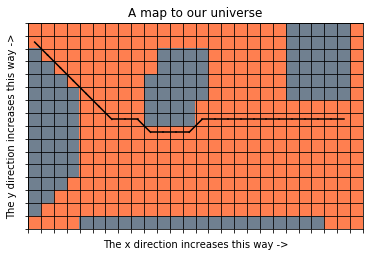

In [14]:
paths = astar_search((1,15), (25,9), heuristic_max)
for i in range(len(paths)):
    paths[i] = (paths[i][0]-1, paths[i][1]-1)
print(paths)
plot_maze(space, path = paths)

<span style="color:steelblue">
I did it!
It's worth noting that, technically speaking, there are several equivalent solutions to this problem, as the step cost of taking each step is 1, in this case and our path options are fairly simple, linear options. Another perfectly valid approach would have been to go directly across (horizontally) until we approached a wall, and then to go down again and then across.
</span>

![image](https://img.buzzfeed.com/buzzfeed-static/static/2015-02/2/8/enhanced/webdr01/anigif_original-grid-image-15541-1422885496-28.gif?crop=450:222;0,12&downsize=715:*&output-format=auto&output-quality=auto)

[Back to top](#top)

<a/ id='p2'></a>

<br>

---
## [25 pts] Problem 2:  Bayesian networks

#### Part A
Suppose we are about to go on a run and are trying to decide how far to run. Consider the Bayesian network depicted below for this decision. The length of our run ($R$, miles) is continuous and depends on the temperature ($T$, degrees Fahrenheit), which is also a continuous variable, and whether or not it is raining ($P$), which is a discrete Boolean variable.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/running_bayesnet.png" style="width: 450px;"/>

1. Read in the data set [`data_running.csv`](https://piazza.com/class_profile/get_resource/jc4v74a5uu5wa/jfv207i7dlqd8) from the Resources tab on Piazza (and linked here).
1. How many data points are there?
1. Make a histogram of the distribution of temperature, with appropriate axis labels.

In [15]:
#Ok. Let's read in the CSV
df = pd.read_csv('data_running.csv')
df.head()

,Unnamed: 0,rain,temperature,length
0,0,Yes,93.255955,7.548189
1,1,No,65.948429,8.586705
2,2,Yes,95.111679,8.002269
3,3,No,67.330186,9.499620
4,4,Yes,85.666279,7.621792


In [16]:
df.count()

Unnamed: 0     200
rain           200
temperature    200
length         200
dtype: int64

----
 
2, How many points are there? 

<span style="color:steelblue"> It would seem that there are 200 points.</span>


----

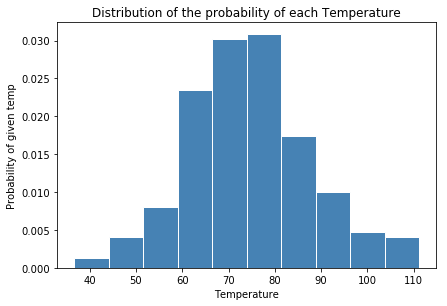

In [17]:
plt.subplots(1, 1)
plt.tight_layout()
plt.hist(df['temperature'],edgecolor = 'white', color = 'steelblue', normed = True)
plt.title("Distribution of the probability of each Temperature")
plt.xlabel("Temperature")
plt.ylabel('Probability of given temp')
plt.show()

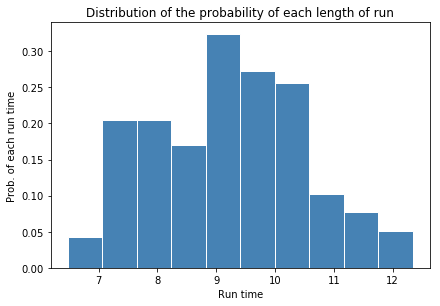

In [18]:
plt.subplots(1, 1)
plt.tight_layout()
plt.hist(df['length'],edgecolor = 'white', color = 'steelblue', normed = True)
plt.title("Distribution of the probability of each length of run")
plt.xlabel("Run time")
plt.ylabel('Prob. of each run time')
plt.show()

<span style="color:steelblue">
This is merely for my own purposes so I can assess the relationships in the data.
</span>

#### Part B

Decide on appropriate prior distributions for $P$ and $T$.  Note that $P$ is discrete (Boolean), while $T$ is continuous.  There is not necessarily only one correct response; your answer should be fully justified by calculations shown below.

 ----

<span style="color:steelblue">
It is clear that, for **P**, it is a **Bernoulli distribution**, as at each step, we want to take a Bernoulli trial with a True or False result; either that it rained, or it did not.
</span> 

<span style="color:steelblue">
Alternatively, it would seem that **T**'s prior distribution follows that of a **Gaussian Distribution**, as there is a normal distribution/bell curve of each of the timings for the length of the run.
</span>

----

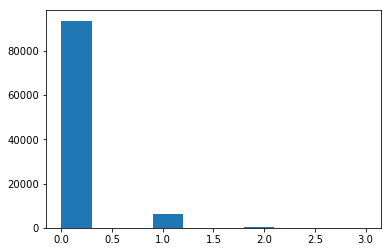

In [19]:
dftrue = df[df['rain'] == 'Yes']
dftrue.count()
num_rained = 200-48
p_rained = (1/(152))

x = np.random.binomial(10, 1/152, 100000)
plt.hist(x)
plt.show()

<span style="color:steelblue">
It would seem that there is a probability of 1/152 chance of it raining, overall- since it can't be *kind of* raining, it's a True/False.
</span>

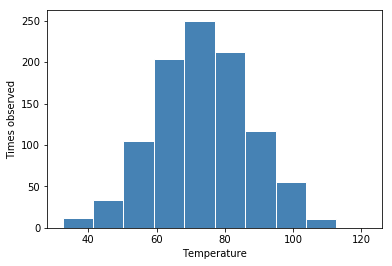

In [20]:
'''
Gaussian distribution of temperature

'''

T_mean = df['temperature'].mean()
T_std = df['temperature'].std()

t_dist = np.random.normal(T_mean, T_std, 1000)
plt.hist(t_dist, color = 'steelblue', edgecolor = 'white')
plt.xlabel("Temperature")
plt.ylabel('Times observed')
plt.show()

#### Part C
1. Make two scatter plots:  one of the relationship between temperature (x-axis) and run length (y-axis) for only the days when it was raining, and one of this relationship for only the days when it was not raining. Label your axes appropriately.
1. Run length is necessarily non-negative, so a log-normal distribution would be appropriate as the conditional probability distribution for $R$, given $P$ and $T$. Let the log-normal parameter related to central tendency vary linearly with $T$, and categorically depending on whether or not it is raining. Keep the log-normal parameter related to distribution spread fixed. 
1. Report the values of all relevant estimated parameters for the conditional probability distribution. There is not necessarily only one correct response; your answer should be fully justified by calculations.

----

# Number 1

1. Make two scatter plots:  one of the relationship between temperature (x-axis) and run length (y-axis) for only the days when it was raining, and one of this relationship for only the days when it was not raining. Label your axes appropriately.

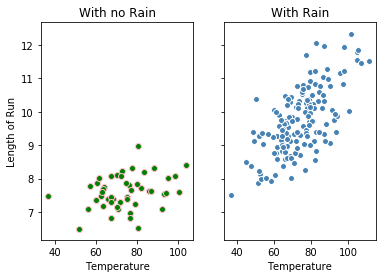

In [21]:
dfRain = df[df['rain'] == "Yes"]
dfNoRain= df[df['rain'] == "No"]

Temp_Y = dfRain['temperature'].values.T.tolist()
Temp_N = dfNoRain['temperature'].values.T.tolist()
Rain_Y = dfRain['length'].values.T.tolist()
Rain_N = dfNoRain['length'].values.T.tolist()

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True)
ax1.scatter(Temp_Y, Rain_Y, color = "green", edgecolor = "pink")
ax1.set_title("With no Rain")
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Length of Run")
ax2.scatter(Temp_N, Rain_N, color = "steelblue", edgecolor = "white")
ax2.set_xlabel("Temperature")
ax2.set_title("With Rain")
plt.show()

----

# Number Two 

2, Run length is necessarily non-negative, so a log-normal distribution would be appropriate as the conditional probability distribution for $R$, given $P$ and $T$. Let the log-normal parameter related to central tendency vary linearly with $T$, and categorically depending on whether or not it is raining. Keep the log-normal parameter related to distribution spread fixed. 

----
<span style="color:steelblue">
So we need to figure out what exaclty our equation is.
Since they vary linearly with one another, there must be some equation such as:
</span>

$\mu = \mu_{0}X  + \mu_{1}$

<span style="color:steelblue">
So, let's calculate a line of best fit for these two and see how they fit together.
</span>

In [22]:
bestfit_rain = stats.linregress(x=dfRain['temperature'], y=dfRain['length'])
bestfit_Norain = stats.linregress(x=dfNoRain['temperature'], y=dfNoRain['length'])

print('Slope estimate is {:0.4f}, intercept estimate is {:0.4f}'.format(bestfit_rain.slope,bestfit_rain.intercept))
print('Slope estimate is {:0.4f}, intercept estimate is {:0.4f}'.format(bestfit_Norain.slope,bestfit_Norain.intercept))

Slope estimate is 0.0110, intercept estimate is 6.7770
Slope estimate is 0.0479, intercept estimate is 6.1817


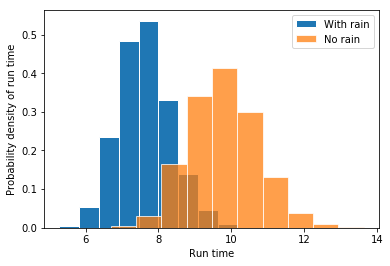

In [23]:
plt.hist(stats.lognorm.rvs(scale = bestfit_rain.slope*dfRain['temperature'].mean() + bestfit_rain.intercept, s = np.log(1.1), size = 10000), edgecolor = 'white', normed = True, label = 'With rain')
plt.hist(stats.lognorm.rvs(scale = bestfit_Norain.slope*dfNoRain['temperature'].mean() + bestfit_Norain.intercept, s = np.log(1.1), size = 10000), edgecolor = 'white', normed = True, label = 'No rain', alpha = 0.75)
plt.xlabel("Run time")
plt.ylabel("Probability density of run time")
plt.legend()
plt.show()

<span style="color:steelblue">
The best estimate for our central tendency will be the slope, wherein the length of our run varies linearly as a function of Temperature.
</span>

<span style="color:steelblue">
Just as a sanity check, let's evaluate what we see here. It would seem that our run times are longer on average on days without rain, and more numerous. Seems to make sense to me! Likewise, run time and temperature are positively correlated.
</span>

----

3, Report the values of all relevant estimated parameters for the conditional probability distribution. There is not necessarily only one correct response; your answer should be fully justified by calculations.

----

<span style="color:steelblue">
We need a few things. Firstly, we need the line of best fit so that we can use the estimated values for the central tendency, as previously mentioned. 
Likewise, we need some value of standard variation.
</span>
<span style="color:steelblue">
Further, using the equation for central tendency, we have a starting point for our scale value for the lognormal distribution.
</span>
<span style="color:steelblue">
I assigned $\sigma$ to be the standard deviation of temperature, as a whole, as it needed to be a fixed value as per our specifications.
</span>

<span style="color:steelblue">
Further, I used the central estimate from the SSE squared line regression tool for slope and beta, to create an equation for the linear relationship of our data. I plugged the mean $\mu$ for each data set into the equation.
</span>

----

In [ ]:
print(f"The mean of data with Rain: {dfRain['temperature'].mean()}")
print(f"The mean of data with no Rain: {dfNoRain['temperature'].mean()}")
sigma = df['temperature'].std()
#and the two equations for our seperate data models

bestfit_rain = stats.linregress(x=dfRain['temperature'], y=dfRain['length'])
bestfit_Norain = stats.linregress(x=dfNoRain['temperature'], y=dfNoRain['length'])

print(f"With rain: Y1 = ax+b, where a = {bestfit_rain.slope} and b = {bestfit_rain.intercept}")
print(f"With no rain: Y2 = ax+b, where a = {bestfit_Norain.slope} and b = {bestfit_Norain.intercept}")

#### Part D

Find the probability distributions for your run length on a day that is 80 degrees Fahrenheit and **not** raining, as well as run length on an 80-degree day when it **is** raining.  Plot these two distributions on the same set of axes, with run length (miles) on the x-axis and probability density on the y-axis. Include a legend and appropriate axis labels.

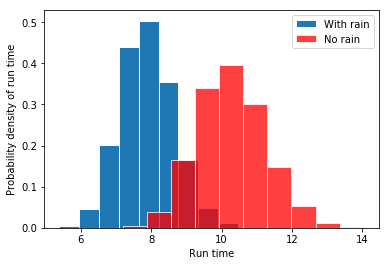

In [25]:
df80Rain = dfRain[dfRain['temperature'] >= 80]
df80Rain = df80Rain[df80Rain['temperature'] < 90]
df80NoRain = dfNoRain[dfNoRain['temperature'] >= 80]
df80NoRain = df80NoRain[df80NoRain['temperature'] < 90]


bestfit80_rain = stats.linregress(x=df80Rain['temperature'], y=df80Rain['length'])
bestfit80_Norain = stats.linregress(x=df80NoRain['temperature'], y=df80NoRain['length'])
r1 = stats.lognorm.rvs(scale = bestfit80_rain.slope*df80Rain['temperature'].mean() + bestfit80_rain.intercept, s = np.log(1.1), size = 10000)
r2 = stats.lognorm.rvs(scale = bestfit80_Norain.slope*df80NoRain['temperature'].mean() + bestfit80_Norain.intercept, s = np.log(1.1), size = 10000)
plt.hist(r1, edgecolor = 'white', normed = True, label = 'With rain')
plt.hist(r2,  alpha = 0.75, edgecolor = 'white', normed = True, label = 'No rain', color = 'red')
plt.xlabel("Run time")
plt.ylabel("Probability density of run time")
plt.legend()
plt.show()

#### Part E

Use approximate Bayesian computation (i.e., sampling) to estimate the probability of going on a run **at least** 8 miles in length. 

In [26]:
r1 = stats.lognorm.rvs(scale = bestfit_rain.slope*dfRain['temperature'].mean() + bestfit_rain.intercept, s = np.log(1.1), size = 10000)
r2 = stats.lognorm.rvs(scale = bestfit_Norain.slope*dfNoRain['temperature'].mean() + bestfit_Norain.intercept, s = np.log(1.1), size = 10000)
runs, runs2, total, total2 = 0, 0, 0, 0
for i in r1:
    if i >= 8: runs += 1
    total += 1
for i in r2:
    if i >= 8: runs2 += 1
    total2 += 1
        
#since we already generated our models before
print(f"Proportion of runs that is greater than or equal to 8 miles long w/ rain: {round(runs/total*100, 2)}%")
print(f"Proportion of runs that is greater than or equal to 8 miles long w/o rain: {round(runs2/total*100, 2)}%")

Proportion of runs that is greater than or equal to 8 miles long w/ rain: 30.12%
Proportion of runs that is greater than or equal to 8 miles long w/o rain: 97.88%


Seems reasonable.

[Back to top](#top)

<a/ id='p3'></a>

---
## [25 pts] Problem 3:  Markov chain Monte Carlo

Consider the problem of estimating the slope and intercept parameters for a linear model. Suppose this linear model represents the amount of ice cream you will consume ($y$, in pints) after going on a bike ride of length $x$ (in miles).

$$y = \alpha x + \beta$$

#### Part A

Fix the $x$ distance values at which we will estimate our ice cream intake covering the 0 to 9.9 range (inclusive), at intervals of 0.1 miles. Let $\alpha^* = 0.5$ and $\beta^* = 8$ represent the true parameters for your linear model. Generate a synthetic data set of ice cream eaten for each bike ride length $x$, assuming that measured ice cream consumption is normally distributed, centered at the true model and with standard deviation $\sigma = 1$. Create a scatter plot of you true model and the "observed" data, with appropriate axis labels and a legend.

**Question:** How many data points are there?

First, let's generate our data.

In [ ]:
astar, bstar, sigma = 0.5, 8, 1
x_grid = np.arange(0, 10, 0.1)
y_true = [astar*x + bstar for x in x_grid]

# x and y values of our synthetic data set
x_meas = np.arange(0, 10, 0.1)
y_meas = [stats.norm.rvs(loc = y, scale = sigma) for y in y_true]

plt.plot(x_grid, y_true, label='$y_{true}$')
plt.scatter(x_grid, y_meas, color='coral', label='$y_{meas}$')
plt.xlabel('Miles biked')
plt.ylabel('Pints consumed')
plt.title("Pints consumed vs. Miles Biked")
plt.legend()
plt.show()

There are 100 data points within our True model. Additionally, there are 100 points within our Measured model. In total, this accumulates to 200 points.

#### Part B

In class, we used the posterior score itself to calculate acceptance probabilities at iteration $t$ for the Metropolis-Hastings algorithm:

$$p_{accept} = \dfrac{\pi(\theta_{new} \mid y_{meas})}{\pi(\theta_{t} \mid y_{meas})},$$

where $\theta_t = (\alpha_t, T_{eq,t})$ are the parameter estimates in our Markov chain at iteration $t$ and $y_{meas}$ is the data.  But it is much more numerically stable to use the natural logarithm of the posterior score in most applications. 

1. Define a log-posterior function to return the logarithm of the posterior score for a given set of parameter values, varying *both* $\alpha$ and $\beta$. Use uniform prior distributions, for $\alpha \in [0,5]$ and $\beta \in [0,15]$. You may assume that $\alpha$ and $\beta$ are independent, so their prior distribution factors as $\pi(\alpha, \beta) = \pi(\alpha) \pi(\beta)$.
2. Calculate the simple least squares regression estimates of $\alpha$ and $\beta$, and report their log-posterior score.

We know a few things then, from this:

The posterior score is going to be something like:

$posterior\ score = L(\theta \mid{Y})*prior$ 

Where $prior = prior_{\alpha} * prior_{\beta}$

1, Define a log-posterior function to return the logarithm of the posterior score for a given set of parameter values, varying *both* $\alpha$ and $\beta$. Use uniform prior distributions, for $\alpha \in [0,5]$ and $\beta \in [0,15]$. You may assume that $\alpha$ and $\beta$ are independent, so their prior distribution factors as $\pi(\alpha, \beta) = \pi(\alpha) \pi(\beta)$.

In [ ]:
def prior(p_alpha, p_beta, a_range = (0,5), b_range = (0, 15)):
    pr_alpha, pr_beta = 0, 0
    pr_alpha = 1/(a_range[1] - a_range[0]) if a_range[0] <= p_alpha <= a_range[1] else pr_alpha
    pr_beta = 1/(b_range[1] - b_range[0]) if b_range[0] <= p_beta <= b_range[1] else pr_beta
    return (pr_alpha * pr_beta)

def posterior(alpha, beta = 8):
    pri = prior(alpha, beta)
    if pri==0:
        return 0
    else:
        return likelihood(alpha, beta)*pri
    
def likelihood(parameter, beta):
    prod = 1
    prod_a = 1
    for i in range(len(x_grid)): #alternate alpha
        delta = (parameter*x_grid[i] + beta) - y_meas[i]
        prod *= stats.norm.pdf(x=delta, loc=0, scale=sigma)
    for j in range(0, 15): #alternate beta
        delta = (prod*x_grid[-1] + j) - y_meas[-1]
        prod_a *= stats.norm.pdf(x=delta, loc=0, scale=sigma)
    return prod_a

def log_posterior(alpha, beta):
    return np.log(posterior(alpha, beta))

In [ ]:
priori = prior(0.5, 8)
print(priori)
print(log_posterior(0.5, 0.8))

2, Calculate the simple least squares regression estimates of $\alpha$ and $\beta$, and report their log-posterior score.

In [ ]:
bestfit = stats.linregress(x=x_meas, y=y_meas)
print('Slope estimate is {:0.4f}, intercept estimate is {:0.4f}'.format(bestfit.slope,bestfit.intercept))

So, we know our estimate for $\beta^{*}$ to be the intercept of this equation, and $\alpha*$ to be the slope, using the Simple Least Squares regression estimates above.

In [ ]:
alpha = bestfit.slope
beta = bestfit.intercept
print(f"(alpha*: {alpha}, beta*: {beta})")

Here, we have their log posterior scores:

In [ ]:
print(log_posterior(0.5, 0.8))

#### Part C

To use the log-posterior as our objective function, we need to modify the Metropolis-Hastings acceptance probability so we can calculate it in terms of posterior scores (the right hand side below):

$$\log{(p_{accept})} = \log{\left(\dfrac{\pi(\theta_{new} \mid y_{meas})}{\pi(\theta_{t} \mid y_{meas})}\right)} = \log{(\pi(\theta_{new} \mid y_{meas}))} - \log{(\pi(\theta_{t} \mid y_{meas}))}$$

If you exponentiate both sides, things should start to look familiar from simulated annealing:

$$\exp{\left[\log{(p_{accept})}\right]} = p_{accept} = \exp{\left[\log{(\pi(\theta_{new} \mid y_{meas}))} - \log{(\pi(\theta_{t} \mid y_{meas}))}\right]}$$

Implement this in the Metropolis-Hastings algorithm.  Use a multivariate normal distribution to propose new parameters $(\alpha, \beta)$ jointly.

In [ ]:
class State:
    def __init__(self, state, value):
        self.state = state
        self.value = value
        
class ProblemMCMC:        
    def __init__(self, initial, posterior, stepsize):
        self.current = initial
        self.post = posterior
        self.stepsize = stepsize
        
    def random_move(self):
        covariance = 0
        next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        return next_move, self.post(next_move)
    
def mcmc(problem1, problem2, n_iter):
    parameters1 = [problem1.current.state]
    posterior1 = [problem1.current.value]
    parameters2 = [problem2.current.state]
    posterior2 = [problem2.current.value]
    
    print(f"Params: P1: {parameters1[0]}, P2: {parameters2[0]}, Posts: p1: {posterior1[0]}, p2: {posterior2[0]}")
    
    for t in range(n_iter):
        #propose a new state
        (new_state1, new_post1) = problem1.random_move()
        (new_state2, new_post2) = problem2.random_move()
        
        #calculate the acceptance probability of our new state
        p_accept1 = (((new_post1)/(posterior1[t]))*(new_post2)/(posterior2[t]))
        #print(p_accept1)
        
        if p_accept1 >= 1:
            
            #add the posterior score of our new proposed state
            posterior1.append(new_post1)
            #add our proposed state to the list of parameters that we have built
            parameters1.append(new_state1)
            problem1.current.state = new_state1
            problem1.current.value = new_post1
            
            #add the posterior score of our new proposed state
            posterior2.append(new_post2)
            #add our proposed state to the list of parameters that we have built
            parameters2.append(new_state2)
            problem2.current.state = new_state2
            problem2.current.value = new_post2
            
            
        if p_accept1 < 1:
            #check to see if we accept our supposed parameter
            selection = np.random.choice([True, False], p = [p_accept1, 1-p_accept1])
            
            if selection == True:
                #add the posterior score of our new proposed state
                posterior1.append(new_post1)
                #add our proposed state to the list of parameters that we have built
                parameters1.append(new_state1)
                problem1.current.state = new_state1
                problem1.current.value = new_post1
                     
                #add the posterior score of our new proposed state
                posterior2.append(new_post2)
                #add our proposed state to the list of parameters that we have built
                parameters2.append(new_state2)
                problem2.current.state = new_state2
                problem2.current.value = new_post2
                
            if selection == False:
                #otherwise, we reject the new parameter and instead
                #add another copy of the current parameter and its
                #corresponding posterior score
                parameters1.append(parameters1[t])
                posterior1.append(posterior1[t])
                parameters2.append(parameters2[t])
                posterior2.append(posterior2[t])

    return (parameters1, parameters2), (posterior1, posterior2)

In [ ]:
print(alpha, beta)

In [ ]:
new_alpha = State(alpha, posterior(alpha, beta))
new_beta = State(beta, posterior(alpha, beta))

mcmc_alpha = ProblemMCMC(new_alpha, posterior, 0.05)
mcmc_beta = ProblemMCMC(new_beta, posterior, 0.05)

In [ ]:
parameters, posteriors = mcmc(mcmc_alpha, mcmc_beta, 5000)

#### Part D

Obtain samples from the posterior distribution of $\alpha$ and $\beta$ by running the Metropolis-Hastings algorithm for 5000 iterations.  Start with the least squares estimates from Part B as the initial values for each parameter. The step sizes for the parameters should be chosen such that the acceptance rate is somewhere between 23 and 44%. Remove the first half of each Markov chain for burn-in, and save the rest for analysis.

1. Create a two-panel figure of the history plots of your Markov chains for each of $\alpha$ and $\beta$. Calculate and report the acceptance rate.
1. Create a two-panel figure of the histograms for your posterior samples for analysis for $\alpha$ and $\beta$. Label your axes appropriately.
1. Below your histogram, report on the 5-95% credible intervals (percentiles) for each parameter, as well as their posterior medians.

In [ ]:
print(np.count_nonzero(np.diff(parameters[1])*np.diff(parameters[0]))/(len(parameters[0])+len(parameters[1])))

#### Part E

Now repeat this experiment, but only include a subsample of 50 data points out of the original set. Generate the same set of plots and diagnostic numbers as Part D. You may need to adjust the step sizes in order to obtain similar acceptance rates.

Compare the 5-95% credible intervals found in Part D and E, and comment on any differences you find.

[Back to top](#top)

<a/ id='p4'></a>

<br>

---
## [25 pts] Problem 4:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a [drone](https://twitter.com/Reuters/status/981121633023705088/video/1) to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if I say the drone is at $(x,y,z)$ I mean that it is in the box centered at $(x,y,z)$. And there are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. So, for example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins each training episode in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, which is just a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, which is a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the heck that landing pad is, and how to get there from any initial state.

In [ ]:
class MDPLanding:
    def __init__(self, L, terminal, default_reward, discount):
        '''Create/store the following attributes:
        states -- list of all the states (x,y) tuples
        terminal_states -- is a dictionary with terminal state keys, and rewards as values
        default_reward -- is the reward for being in any non-terminal state
        df -- discount factor
        ... and anything else you decide will be useful!
        '''
        self.states = [(x, y, z) for x in range(1, L+1) for y in range(1, L+1) for z in range(1, L+1)]
        self.L = L
        self.terminals = terminal
        self.rewards = default_reward
        self.discount = discount

    def actions(self, state):
        '''Return a list of available actions from the given state.
        [None] are the actions available from a terminal state.
        '''
        actions = []
        if state in self.terminals:
            return [None]
        else:
            if state[0] - 1 > 0: #left boundary
                actions.append('-x')
                if state[0] -1 == 0:
                    actions.append([None])
            if state[0] + 1 < self.L: #right boundary
                if state[0] + 1 == self.L:
                    actions.append([None])
                actions.append('+x')
            if state[1] - 1 > 0: #down boundary
                if state[1]-1 == 0:
                    actions.append([None])
                actions.append('-y')
            if state[1] + 1 < self.L: #up boundary
                actions.append('+y')
                if state[1] + 1 == self.L:
                    actions.append([None])
            if state[2] - 1 > 0: #Z Down boundary
                actions.append('-z')
                if state[2] -1 == 0:
                    actions.append([None])
            if state[2] + 1 < self.L: #Z Up boundary
                if state[2] + 1 == self.L:
                    actions.append([None])
                actions.append('+z')
        return actions
            
        
    def reward(self, state):
        '''Return the reward for being in the given state'''
        if state in self.terminals: 
            return self.terminals[state]
        else: 
            return self.rewards
 
        
    def result(self, state, action):
        '''Return the resulting state (as a tuple) from doing the given
        action in the given state, without uncertainty. Uncertainty
        is incorporated into the transition method.
        state -- a tuple representing the current state
        action -- one of N, S, E or W, as a string
        '''
        
        if action == '+y':
            return (state[0], state[1]+ 1, state[2])
        elif action == '-y':
            return (state[0], state[1]- 1, state[2])
        elif action == '+x':
            return (state[0] +1, state[1], state[2])
        elif action == '-x':
            return (state[0] - 1, state[1], state[2])
        elif action == '+z':
            return (state[0], state[1], state[2] + 1)
        elif action == '-z':
            return (state[0], state[1], state[2] -1)
        elif action == [None] or action == None:
            return (state)
        
        
    def transition(self, state, action):
        '''Return the probabilities and subsequent states associated
        with taking the given action from the given state. Can be done
        however you want, so that it works with your value/policy iteration.
        '''
        probs = {}
        possible = self.actions(state)
        move = self.result(state, action)
        
        for i in possible:
            if i == action:
                probs[action] = 1
            else:
                probs[i] =  1
        return (tuple(move),probs)


#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and comment on the results:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

---

<span style="color:steelblue">
Since we have no sample data, let's say that the **Landing pad** is at $(1,1,1)$
and that there are three terminal states that are not the landing pad, $(3,3,3)$, $(3,4,3)$, $(2,3,1)$.
</span>


---

In [ ]:
def policy_iteration(mdp, U):
    policy = {states: '+x' for states in mdp.states}
    for states in mdp.states:
        best_action = expected_utility('+x', states, U, mdp)
        for action in mdp.actions(states):
            temp = expected_utility(action, states, U, mdp)
            if temp > best_action[0]:
                best_action = (temp, action)
        policy[states] = best_action[1]
    return policy

In [ ]:
def expected_utility(a, s, U, mdp):
    "The expected utility of doing a in state s, according to the MDP and U."
    return sum([p * U[s1] for (p, s1) in mdp.transition(s, a)])

In [ ]:
terminal = {}
default_reward = -0.01
discount = 0.99
mdp = MDPLanding(4, terminal, default_reward, discount)

In [ ]:
print(f"(1,5):{U[(2,2,1)]}, (6,1): {U[(2,2,1)]}")
print(f"(2,5): {U[(0,2,1)]}, (5,3): {U[(0,2,1)]}")
print(f"Policy, (2,4): {P[(2,0,1)]}, Policy, (1,1): {P[(2,0,1)]}")

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values (see Section 21.3.2 in the textbook).  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. I refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever variety you would like.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your codes.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

<a/ id='bottom'></a>

[Back to top](#top)